In [1]:
import numpy as np
import os
from PIL import Image
import torch
import cv2
from torch.autograd import Variable
from SSD.data import BaseTransform,VOC_CLASSES as mapping
from SSD.ssd import build_ssd
import pickle as pkl
import matplotlib.pyplot as plt
from keras.models import load_model
from preprocessing import preprocess
from sklearn.metrics import classification_report

C:\Users\Dell\Desktop\Illegal_Parking


Using TensorFlow backend.


In [82]:
model=build_ssd('test')
model.load_state_dict(torch.load("SSD/ssd300_mAP_77.43_v2.pth",map_location=lambda storage,loc:storage))
transform=BaseTransform(model.size,(104/256.0,117/256.0,123/256.0))

cls=load_model("IP_model_2.h5")

C:\Users\Dell\Desktop\Illegal_Parking\SSD\ssd.py:33: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)
C:\Users\Dell\Desktop\Illegal_Parking\SSD\layers\modules\l2norm.py:17: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.weight,self.gamma)


In [83]:
def detect(frame , net , trans):
    height,width=frame.shape[:2]
    frame_t=trans(frame)[0]
    x=torch.from_numpy(frame_t).permute(2,0,1)      #rgb to grb
    x=Variable(x.unsqueeze(0))
    y=net(x)
    detectioins=y.data    #[batch,class,num_class,(score,x0,y0,x1,y1)]
    scale=torch.Tensor([width,height,width,height])
    i=7  #for cars
    num=0
    coor=[]
    labels=[]
    while detectioins[0,i,num,0]>=0.6 and mapping[i-1]=="car":
        points=detectioins[0,i,num,1:]
        points=points*scale
        points=points.numpy()
        num+=1
        coor.append(points)
    return (num,sorted(coor,key=lambda x : x[0]))

def pretransform(img ,coor):
    im=img.copy()
    return cv2.rectangle(im,(int(coor[0]),int(coor[1])),(int(coor[2]),int(coor[3])),(0,0,0),cv2.FILLED)

In [84]:
def show_details(img,data,preds,mode=0):
    for i in range(data[0]):
        if(preds[0]==0):
            img=cv2.rectangle(img,(int(data[1][i][0]),int(data[1][i][1])),(int(data[1][i][2]),int(data[1][i][3])),(0,255,0),2)
        else:
            img=cv2.rectangle(img,(int(data[1][i][0]),int(data[1][i][1])),(int(data[1][i][2]),int(data[1][i][3])),(255,0,0),2)
    if mode==0:
        plt.imshow(img)
        return
    return img
    
def predict_parking(image):
    img=image.copy()
    data=detect(frame=img,net=model,trans=transform)
    predictions=[]
    for num in range(data[0]):
        im=img.copy()
        im=pretransform(im,data[1][num])
        predictions.append(cls.predict_classes([[img]]))
    return data,predictions

In [85]:
lab=os.listdir("./Data/images/")
len(lab)

180

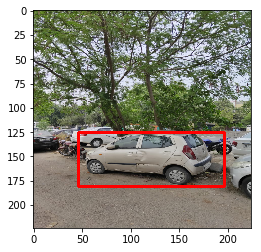

In [86]:
a=np.random.randint(0,len(lab))
img=cv2.resize(cv2.imread("./Data/images/"+lab[a]),(224,224))

data,preds=predict_parking(img)

show_details(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),data,preds)

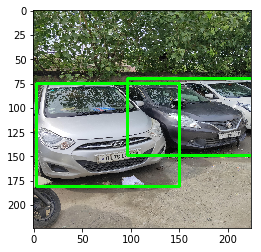

In [87]:
img=cv2.resize(cv2.imread("./Data/Test_im/IMG20190718153549.jpg"),(224,224))
# img=cv2.resize(cv2.imread("./Data/Test_im/IMG20190716154504.jpg"),(224,224))

data,preds=predict_parking(img)

show_details(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),data,preds)

In [88]:
test=os.listdir("./Data/Test_im/")
len(test)

84

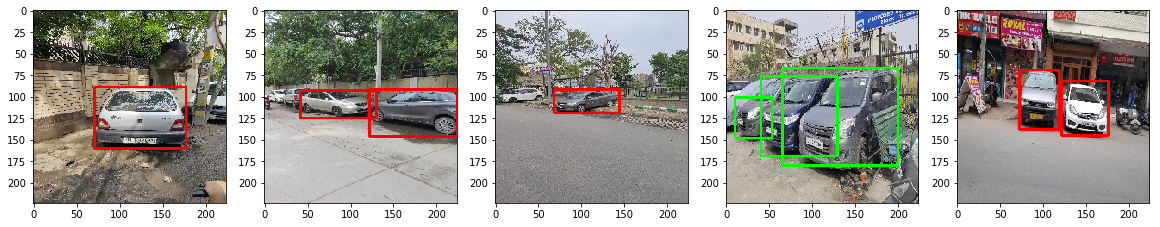

In [89]:
fig=plt.figure(figsize=(20,20))
num=1
np.random.shuffle(test)
for test_img in test[:5]:
    ax=fig.add_subplot(1,5,num)
    num+=1
    img=cv2.resize(cv2.imread("./Data/Test_im/"+test_img),(224,224))
    data,preds=predict_parking(img)
    img=show_details(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),data,preds,1)
    ax.imshow(img)
    

In [130]:
with open("./Data/test_labels.pickle","rb") as file:
    test_labels=pkl.load(file)

In [131]:
def simplify_labels(labels):
    new_labels=[]
    for image in labels:
        for num in range(image[1][0]):
            new_labels.append((image[0],(1,[image[1][1][num]],[image[1][2][num]])))
    return new_labels

test_labels=simplify_labels(test_labels)
np.random.shuffle(test_labels)
len(test_labels)

138

In [132]:
gen=preprocess(test_labels,"./Data/Test_im/",139)
test_data,test_target=next(gen)

In [133]:
test_labels[80]

('IMG20190718153923.jpg',
 (1,
  [array([ 58.875847,  89.48145 , 132.85957 , 125.336044], dtype=float32)],
  ['1']))

In [135]:
preds=[]
for i in range(len(target)):
    preds.append(cls.predict_classes([[test_data[i]]]))
preds=np.array(preds)
preds=preds.reshape((-1,))

In [136]:
print(classification_report(test_target,preds))

              precision    recall  f1-score   support

           0       0.47      0.67      0.55        55
           1       0.70      0.50      0.58        84

    accuracy                           0.57       139
   macro avg       0.58      0.59      0.57       139
weighted avg       0.61      0.57      0.57       139



In [137]:
(preds==test_target).sum()/len(preds)

0.5683453237410072

In [138]:
with open("./testing_data.pickle","wb") as file:
    pkl.dump([test_data,test_target],file)